In [1]:
from scipy.io import loadmat
import numpy as np
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ExpSineSquared

GP for NARX

In [2]:
out = loadmat(f'UnbalancedDisk-sim-data.mat') 
x = out['ulist'][0,:] 
y = out['ylist'][0,:] 
# x=x[0:10000]
# y=y[0:10000]
x=x[0:3000]
y=y[0:3000]

In [3]:
def kernal(x1, x2, sigma2_ker):
    diff = x1[:,None] - x2[None,:] 
    Kxx = np.exp(-diff**2/(2*sigma2_ker))
    return Kxx

def compute_alpha(x, y, sigma2_es, sigma2_ker):
    Kxx = kernal(x, x, sigma2_ker) 
    alpha = np.linalg.solve(Kxx+sigma2_es*np.eye(len(x)), y) 
    return alpha, Kxx

def pred_mean_and_var(xtest, x, Kxx, alpha, sigma2_es, sigma2_ker, return_std=True): 
    K = lambda x1,x2: kernal(x1, x2, sigma2_ker=sigma2_ker)  
    Ktx = K(xtest, x) 
    Ypred_mean = Ktx@alpha   
    if not return_std:
        return Ypred_mean
    Ypred_var = np.diag(K(xtest,xtest) - Ktx@np.linalg.solve(Kxx+sigma2_es*np.eye(len(x)), Ktx.T))
    return Ypred_mean, Ypred_var**0.5

In [4]:
na, nb = 2, 2
np.random.seed(42)
N = 500
ulist = x
ylist = y
def make_training_data(ulist,ylist,na,nb):
    Xdata = []
    Ydata = []
    #for loop over the data:
    for k in range(max(na,nb),len(ulist)):
        Xdata.append(np.concatenate([ulist[k-nb:k],ylist[k-na:k]])) 
        Ydata.append(ylist[k]) 
    return np.array(Xdata), np.array(Ydata)

Xdata, Ydata = make_training_data(ulist,ylist, na, nb)

from sklearn.model_selection import train_test_split 
Xtrain, Xval, Ytrain, Yval = train_test_split(Xdata, Ydata) 

In [5]:
#fitting
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ExpSineSquared
ker = RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01) 
reg = GaussianProcessRegressor(ker, n_restarts_optimizer=10) 
reg.fit(Xtrain,Ytrain)

GaussianProcessRegressor(kernel=RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01),
                         n_restarts_optimizer=10)

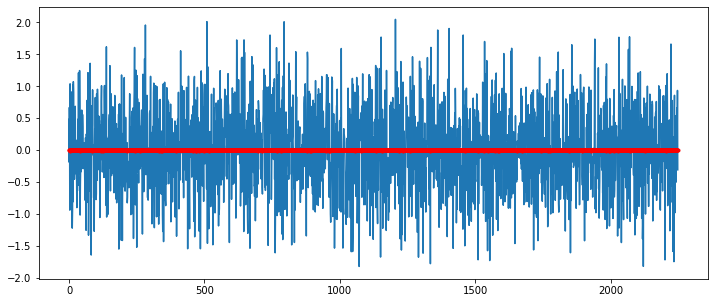

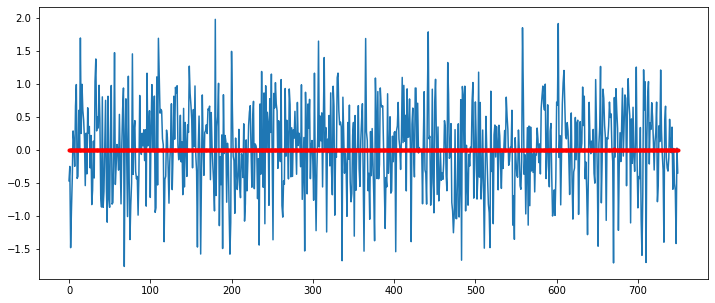

In [6]:
#residual calculations and plotting
Ytrain_pred, Ytrain_pred_std = reg.predict(Xtrain,return_std=True) 
res_t = Ytrain_pred - Ytrain 
plt.figure(figsize=(12,5)) 
plt.plot(Ytrain) 
# Ytrain_pred, Ytrain_pred_std = reg.predict(Xtrain,return_std=True) 
plt.errorbar(np.arange(len(Xtrain)), (reg.predict(Xtrain)-Ytrain), yerr=2*Ytrain_pred_std,fmt='.r') 

plt.show() 
plt.figure(figsize=(12,5)) 
plt.plot(Yval)
Yval_pred, Yval_pred_std = reg.predict(Xval,return_std=True)
res_v=Yval_pred-Yval
plt.errorbar(np.arange(len(Xval)), (reg.predict(Xval)-Yval), yerr=2*Yval_pred_std,fmt='.r') 
plt.show() 


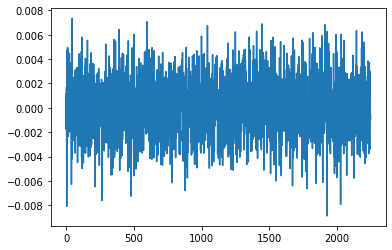

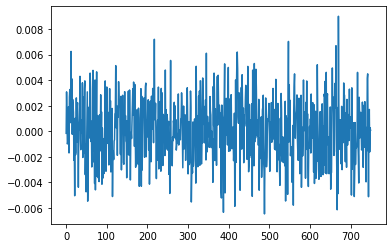

In [7]:
plt.plot(res_t)
plt.show()
plt.plot(res_v)
plt.show()

In [25]:
max(res_v)

0.007292160390166003